# ROICaT Interactive Tracking Colab Notebook

Welcome to the interactive tracking notebook! This Colab notebook allows you to easily and interactively track ROIs in your calcium imaging data over multiple sessions, using a stable version of [ROICaT](https://github.com/RichieHakim/ROICaT). \
This notebook goes through each step and allows you to tune parameters and view how it changes the results.

This Colab notebook is designed to work with  **Suite2p output file** (stat.npy and ops.npy).


**Before we start**

We **STRONGLY** recommend running this Colab notebook with GPU. Please check your runtime setting:

_Runtime -> Change runtime type -> Hardware accelerator -> choose GPU_


**More information**

FAQ on how to play with ROICaT is [here](https://roicat.readthedocs.io/en/dev/).

If you have any questions not covered in the FAQ, please don't hesitate to open a new issue tap on [ROICaT github page](https://github.com/RichieHakim/ROICaT/issues).

**The notebook proceeds as follows:**
1. **Import** libraries
2. Define **paths** to data
3. Run data through the **pipeline**. Each step of the pipeline is run by a single unique python class.
4. **Visualize** results
5. **Save** results

As you go through the notebook, we will explicitly ask you to choose the small number of parameters that are **'important parameters'**. We consider these to be the only parameters that can have a large effect on the run output. Other parameters matter and should be considered as well, but are less critical.

# SETUP

In [ ]:
#@title Install ROICaT
#@markdown Please execute this cell by pressing the _Play_ button on the left. This process will take less than 5 min.

#@markdown Please note that this cell installs ROICaT on the Colab **TEMPORARY** directory in the cloud, not on your local machine or google drive.

#@markdown After running this cell, kernal **automatically RESTARTS**.

# Install ROICaT
!pip uninstall -y tensorflow # Uninstall default tensorflow to avoid any potential conflict
!pip install --user "roicat[tracking] @ git+https://github.com/RichieHakim/ROICaT.git@dev"

print("Restart runtime!")
import os
os._exit(0)

Found existing installation: tensorflow 2.12.0
Uninstalling tensorflow-2.12.0:
  Successfully uninstalled tensorflow-2.12.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/RichieHakim/ROICaT.git (to revision dev) to /tmp/pip-install-q6w6fi6n/roicat_44153e8653864ad4b147aa00732f4668
  Running command git clone --filter=blob:none --quiet https://github.com/RichieHakim/ROICaT.git /tmp/pip-install-q6w6fi6n/roicat_44153e8653864ad4b147aa00732f4668
  Running command git checkout -b dev --track origin/dev
  Switched to a new branch 'dev'
  Branch 'dev' set up to track remote branch 'dev' from 'origin'.
  Resolved https://github.com/RichieHakim/ROICaT.git to commit 996bd53d6540b6c802539df093e1b805048e38d2
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 97.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Prepa

In [ ]:
#@title Import libraries

## Load basic modules
import os
import sys
import zipfile
from pathlib import Path
import copy
from functools import partial
from datetime import datetime
from tqdm import tqdm

import natsort
import gc
import time
import functools
import multiprocessing as mp

import random
import numpy as np
import sklearn
import scipy.sparse

import torch
import torchvision

## Load plotting modules
import matplotlib.pyplot as plt
from ipywidgets import widgets, Button, Output
from IPython.display import display

## roicat
import roicat

In [ ]:
#@title Load helper functions
def set_device():
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print("GPU is available")
    else:
        device = torch.device("cpu")
        print("GPU is not available, using CPU instead")
    return device

def dataloader_params_wrapper(colab_device):
  dataloader_params = {}
  if colab_device == torch.device('cuda'):
    print("Using GPU")
    dataloader_params['batchSize_dataloader'] = 8  ## (advanced) PyTorch dataloader batch_size
    dataloader_params['pinMemory_dataloader'] = True  ## (advanced) PyTorch dataloader pin_memory
    dataloader_params['numWorkers_dataloader'] = -1  ## (advanced) PyTorch dataloader num_workers
    dataloader_params['persistentWorkers_dataloader'] = True  ## (advanced) PyTorch dataloader persistent_workers
    dataloader_params['prefetchFactor_dataloader'] = 2  ## (advanced) PyTorch dataloader prefetch_factor
  elif colab_device == torch.device('cpu'):
    print("Using CPU")
    dataloader_params['batchSize_dataloader'] = 1
    dataloader_params['pinMemory_dataloader'] = False
    dataloader_params['numWorkers_dataloader'] = 0
    dataloader_params['persistentWorkers_dataloader'] = False
    dataloader_params['prefetchFactor_dataloader'] = None
  else:
    print("Unknown environment. Please double-check your runtime setting.")
  return dataloader_params

## Checkbox widget
def checkbox_widget(input_list):
  checkboxes = []
  for input in input_list:
    checkbox = widgets.Checkbox(description=input, value=True)
    checkboxes.append(checkbox)

  selected_indices = []
  return checkboxes, selected_indices

def get_selected_indices(checkboxes):
  indices = [i for i, checkbox in enumerate(checkboxes) if checkbox.value]
  return indices

def make_checkbox_button_clicked(checkboxes, selected_indices):
  def checkbox_button_clicked(_):
    # _ is a placeholder argument to handle button click event
    # Clear the list
    selected_indices.clear()
    # Add the newly selected indices
    selected_indices.extend(get_selected_indices(checkboxes))
  return checkbox_button_clicked

## Slider widget
def create_image_widget_function(images, dpi = 96, cmap='gray'):
  def image_widget(session):
    plt.figure(figsize = (data.FOV_width / dpi, data.FOV_height / dpi))
    plt.imshow(images[session], cmap=cmap)
    plt.show()
  return image_widget

def create_slider_button_function(slider, button_name='Select ref.session!'):
    slider_value = [None]  # Should be a list

    def get_slider_value(_):
        slider_value[0] = slider.value
        print(f'Reference session: {slider_value[0]}')

    button = widgets.Button(description=button_name)

    def slider_on_button_click(_):
        get_slider_value(_)

    button.on_click(slider_on_button_click)

    return button, slider_value

## Set device
DEVICE = roicat.helpers.set_device(use_GPU=True, verbose=True)

tic = time.time()
toc = {}
toc['start'] = time.time() - tic

devices available: [_CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15101MB, multi_processor_count=40)]
Using device: 'cuda:0': _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15101MB, multi_processor_count=40)


# Import paths

### OPTION 1: Mount google drive (RECOMMENDED)

In [ ]:
#@markdown Upload your data to Google Drive, then mount the drive and access the cloud directory here.

#@markdown You can use the sidebar to the left to browse your google drive directories.

from google.colab import drive
path_gdrive = '/content/gdrive'
drive.mount(path_gdrive, force_remount=True)

Mounted at /content/gdrive


In [ ]:
#@markdown ### Enter your google drive directory containing suite2p files:
dir_s2p = '/content/gdrive/MyDrive/Colab_Notebooks/ROICaT_notebooks/statFiles/' #@param {type:"string"}

### OPTION 2: Upload file from local (slower)

In [ ]:
#@markdown Load files from local.

#@markdown For a **nested** folder structure from multiple sessions: Create and upload a **zip file** containing all the folders. stat.npy and ops.npy files from the same session should be in a folder with each other and separate from other sessions.

from google.colab import files
uploaded = files.upload()

for file_name in list(uploaded.keys()):
  file_path = Path.cwd() / file_name
  if file_path.exists():
    if zipfile.is_zipfile(file_path):
      print("Zip file detected: ", file_path)
      with zipfile.ZipFile(file_path, 'r') as zip_ref:
        zip_ref.extractall(Path.cwd())
        print("Zip file extracted to: ", Path.cwd())
    else:
      print("Uploaded file is not zip file: ", file_path)
  else:
    print("Failed to detect uploaded file path: ", file_path)

dir_s2p = os.getcwd()

toc['import_paths'] = time.time() - tic

### Select sessions to track

In [ ]:
#@markdown **Automatically find files by name:**

statFile = 'stat.npy' #@param {type:"string"}
opsFile = 'ops.npy' #@param {type:"string"}
#@markdown **Default: stat.npy, ops.npy**, _type: str_

paths_statFiles = roicat.helpers.find_paths(dir_outer=dir_s2p, reMatch=statFile, depth=8)
paths_opsFiles = roicat.helpers.find_paths(dir_outer=dir_s2p, reMatch=opsFile, depth=8)
print('paths_statFiles')
display(paths_statFiles)
print('paths_opsFiles')
display(paths_opsFiles)

# Default Stat / Ops files
paths_allStat = paths_statFiles
paths_allOps = paths_opsFiles

stat_list = ['/'.join(Path(statfile).parts[-3:]) for statfile in paths_statFiles]
stat_checkboxes, selected_indices = checkbox_widget(stat_list)
checkbox_display = widgets.VBox(stat_checkboxes)
display(checkbox_display)
button = Button(description="Get Stat Files")
button.on_click(make_checkbox_button_clicked(stat_checkboxes, selected_indices))

display(button)

toc['import_paths'] = time.time() - tic

paths_statFiles


['/content/gdrive/MyDrive/Colab_Notebooks/ROICaT_notebooks/statFiles/20230419/stat.npy',
 '/content/gdrive/MyDrive/Colab_Notebooks/ROICaT_notebooks/statFiles/20230420/stat.npy',
 '/content/gdrive/MyDrive/Colab_Notebooks/ROICaT_notebooks/statFiles/20230424/stat.npy',
 '/content/gdrive/MyDrive/Colab_Notebooks/ROICaT_notebooks/statFiles/20230425/stat.npy',
 '/content/gdrive/MyDrive/Colab_Notebooks/ROICaT_notebooks/statFiles/20230426/stat.npy',
 '/content/gdrive/MyDrive/Colab_Notebooks/ROICaT_notebooks/statFiles/20230427/stat.npy',
 '/content/gdrive/MyDrive/Colab_Notebooks/ROICaT_notebooks/statFiles/20230428/stat.npy',
 '/content/gdrive/MyDrive/Colab_Notebooks/ROICaT_notebooks/statFiles/20230429/stat.npy',
 '/content/gdrive/MyDrive/Colab_Notebooks/ROICaT_notebooks/statFiles/20230430/stat.npy',
 '/content/gdrive/MyDrive/Colab_Notebooks/ROICaT_notebooks/statFiles/20230501/stat.npy',
 '/content/gdrive/MyDrive/Colab_Notebooks/ROICaT_notebooks/statFiles/20230502/stat.npy',
 '/content/gdrive/MyD

paths_opsFiles


['/content/gdrive/MyDrive/Colab_Notebooks/ROICaT_notebooks/statFiles/20230419/ops.npy',
 '/content/gdrive/MyDrive/Colab_Notebooks/ROICaT_notebooks/statFiles/20230420/ops.npy',
 '/content/gdrive/MyDrive/Colab_Notebooks/ROICaT_notebooks/statFiles/20230424/ops.npy',
 '/content/gdrive/MyDrive/Colab_Notebooks/ROICaT_notebooks/statFiles/20230425/ops.npy',
 '/content/gdrive/MyDrive/Colab_Notebooks/ROICaT_notebooks/statFiles/20230426/ops.npy',
 '/content/gdrive/MyDrive/Colab_Notebooks/ROICaT_notebooks/statFiles/20230427/ops.npy',
 '/content/gdrive/MyDrive/Colab_Notebooks/ROICaT_notebooks/statFiles/20230428/ops.npy',
 '/content/gdrive/MyDrive/Colab_Notebooks/ROICaT_notebooks/statFiles/20230429/ops.npy',
 '/content/gdrive/MyDrive/Colab_Notebooks/ROICaT_notebooks/statFiles/20230430/ops.npy',
 '/content/gdrive/MyDrive/Colab_Notebooks/ROICaT_notebooks/statFiles/20230501/ops.npy',
 '/content/gdrive/MyDrive/Colab_Notebooks/ROICaT_notebooks/statFiles/20230502/ops.npy',
 '/content/gdrive/MyDrive/Colab_

Button(description='Get Stat Files', style=ButtonStyle())

In [ ]:
#@markdown Selected sessions to track:

stat_selected_indices = ops_selected_indices = selected_indices

paths_allStat = [paths_statFiles[i] for i in stat_selected_indices]
print("Stat files")
display(paths_allStat)
paths_allOps = [paths_opsFiles[i] for i in ops_selected_indices]
print("Ops files")
display(paths_allOps)

Stat files


['/content/gdrive/MyDrive/Colab_Notebooks/ROICaT_notebooks/statFiles/20230502/stat.npy',
 '/content/gdrive/MyDrive/Colab_Notebooks/ROICaT_notebooks/statFiles/20230503/stat.npy',
 '/content/gdrive/MyDrive/Colab_Notebooks/ROICaT_notebooks/statFiles/20230504/stat.npy',
 '/content/gdrive/MyDrive/Colab_Notebooks/ROICaT_notebooks/statFiles/20230505/stat.npy',
 '/content/gdrive/MyDrive/Colab_Notebooks/ROICaT_notebooks/statFiles/20230506/stat.npy']

Ops files


['/content/gdrive/MyDrive/Colab_Notebooks/ROICaT_notebooks/statFiles/20230502/ops.npy',
 '/content/gdrive/MyDrive/Colab_Notebooks/ROICaT_notebooks/statFiles/20230503/ops.npy',
 '/content/gdrive/MyDrive/Colab_Notebooks/ROICaT_notebooks/statFiles/20230504/ops.npy',
 '/content/gdrive/MyDrive/Colab_Notebooks/ROICaT_notebooks/statFiles/20230505/ops.npy',
 '/content/gdrive/MyDrive/Colab_Notebooks/ROICaT_notebooks/statFiles/20230506/ops.npy']

# Import data

In [ ]:
#@markdown ### Enter micrometers per pixel of the imaging FOV (no need to be accurate):
um_per_pixel = 2.5 #@param {type:"number"}
#@markdown **Default: 2.5**, _type: float_
visualize_ROI_size = [int(90/um_per_pixel), int(90/um_per_pixel)]

In [ ]:
#@markdown Load ROIs.

data = roicat.data_importing.Data_suite2p(
    paths_statFiles=paths_allStat[:],
    paths_opsFiles=paths_allOps[:],
    um_per_pixel=um_per_pixel,
    new_or_old_suite2p='new',
    out_height_width=visualize_ROI_size,
    type_meanImg='meanImgE',
    verbose=True,
)

assert data.check_completeness(verbose=False)['tracking'], f"Data object is missing attributes necessary for tracking."

toc['import_data'] = time.time() - tic

Starting: Importing FOV images from ops files
Completed: Set FOV_height and FOV_width successfully.
Completed: Imported 5 FOV images.
Completed: Set FOV_images for 5 sessions successfully.
Importing spatial footprints from stat files.


100%|██████████| 5/5 [00:05<00:00,  1.18s/it]


Imported 5 sessions of spatial footprints into sparse arrays.
Completed: Set spatialFootprints for 5 sessions successfully.
Completed: Created session_bool.
Completed: Created centroids.
Staring: Creating centered ROI images from spatial footprints...
Completed: Created ROI images.


In [ ]:
#@markdown FOV visualization
display("FOV below")
roicat.visualization.display_toggle_image_stack(data.FOV_images)

display("Spatial Footprints below")
roicat.visualization.display_toggle_image_stack([sf.max(0).reshape(data.FOV_height, data.FOV_width).toarray() for sf in data.spatialFootprints], clim=[0,0.05])

Output hidden; open in https://colab.research.google.com to view.

# Alignment

This is the most important step in the pipeline to stop and check that everything looks okay and tune parameters if necessary. I strongly recommend reading the [documentation](https://roicat.readthedocs.io/en/dev/) for the methods for the `roicat.tracking.alignment.Aligner` class at each step.

Alignment is 4 steps:

1. FOV_image augmentation
2. Fit geometric transformation
3. Fit non-rigid transformation (on top of the geometric)
4. Apply transformation to ROIs

###1. FOV_image augmentation
Here the code augments the FOV images by mixing the FOV with the ROI images. Do what is necessary to make the augmented FOV_images look good. Use the visualization tool below to help. This can include using different FOV_images, playing with the mixing factor, and playing with the CLAHE parameters.

In [ ]:
roi_FOV_mixing_factor = 0.5 #@param {type:"number"}
#@markdown The factor by which to mix the ROI images into the FOV images. 0 means no mixing. **Default: 0.5**, _type: float_

#@markdown

use_CLAHE = True #@param {type:"boolean"}
#@markdown **True for Suite2p**. Also useful if images are not contrast enhanced. **Default: True (check)**
CLAHE_grid_size = 1 #@param {type:"number"}
#@markdown The number of equally sized rectangular tiles (in row and column) for CLAHE. **Default: 1**, _type: int_
CLAHE_clipLimit = 1 #@param {type:"number"}
#@markdown A higher _CLAHE_clipLimit_ allows for more contrast but risks amplifying noise.
#@markdown
#@markdown  1.0 or lower value results in **standard (non-contrast limited) AHE**. **Default: 1**, _type: float_
CLAHE_normalize = True #@param {type:"boolean"}
#@markdown Whether to normalize the CLAHE output. **Default: True (check)**


aligner = roicat.tracking.alignment.Aligner(verbose=True)

FOV_images = aligner.augment_FOV_images(
    ims=data.FOV_images,
    spatialFootprints=data.spatialFootprints,
    roi_FOV_mixing_factor=roi_FOV_mixing_factor,
    use_CLAHE=use_CLAHE,
    CLAHE_grid_size=CLAHE_grid_size,
    CLAHE_clipLimit=CLAHE_clipLimit,
    CLAHE_normalize=CLAHE_normalize,
)

roicat.visualization.display_toggle_image_stack(data.FOV_images)

Output hidden; open in https://colab.research.google.com to view.

###2. Fit geometric transformation
Play with parameters until the aligned FOV_images look good. The visualization tool below can help.

In [ ]:
#@markdown **Please select Reference Session by the _Select ref.session!_ button:**

dpi = 96 #@param {type:"number"}
#@markdown Pixel per inch. Controls image size. Smaller dpi, larger image. **Default: 96**, _type: int_

cmap = 'gray' #@param ['gray', 'viridis'] {type:"raw"}
#@markdown Image colormap. **Default: 'gray'**

#@markdown

#@markdown Note that widget response is a bit slow.


# Create a slider, a button, and variable holder for the chosen reference session:
slider = widgets.IntSlider(min=0, max=len(data.FOV_images)-1)
button, reference_session = create_slider_button_function(slider)

# Use the created function with an interactive slider
widgets.interact(create_image_widget_function(data.FOV_images, dpi = dpi, cmap = cmap), session = slider)

# Display the button
display(button)

interactive(children=(IntSlider(value=0, description='session', max=4), Output()), _dom_classes=('widget-inter…

Reference session: 0


Finding geometric registration warps with mode: homography, template_method: sequential, mask_borders: True


Finding geometric registration warps: 100%|██████████| 5/5 [00:08<00:00,  1.63s/it]


Composing geometric warp matrices...
Applying geometric registration warps to images...



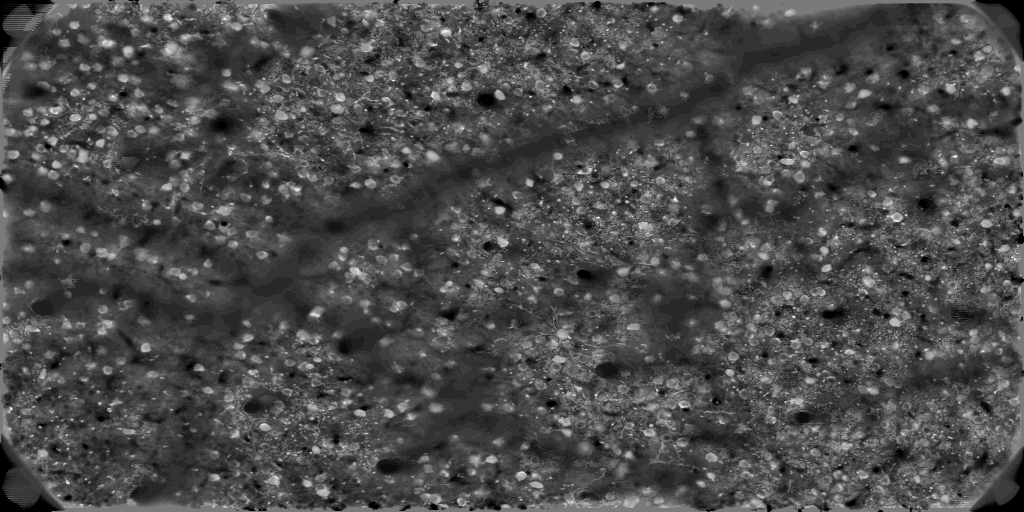

In [ ]:
template_method = 'sequential' #@param ['sequential', 'image'] {type:"raw"}
#@markdown 'sequential' aligns images to neighboring images. Good for drifting data. **Default: 'sequential'**

#@markdown
mode_transform = 'homography' #@param ['homography', 'translation', 'euclidean', 'affine'] {type:"raw"}
#@markdown Type of geometric transformation. **Default: 'homography'**
mask_borders = 50, 50, 50, 50 #@param {type:"raw"}
#@markdown The number of pixels to mask off the edges (top, bottom, left, right). **Default: 50, 50, 50, 50**, _type: tuple_

#@markdown
gaussFiltSize = 31 #@param {type:"number"}
#@markdown The size of gaussian blurring filter applied to all images. **Default: 31**, _type: int_
auto_fix_gaussFilt_step = 10 #@param {type:"number"}
#@markdown Increment in gaussFiltSize after a failed optimization. **Default: 10**, _type: int_


# Geometric warp
aligner.fit_geometric(
    template=reference_session[0],  ## specifies which session image to use as the template.
    ims_moving=FOV_images,  ## input images
    template_method=template_method,  ## 'sequential': align images to neighboring images (good for drifting data). 'image': align to a single image
    mode_transform=mode_transform,  ## type of geometric transformation. See openCV's cv2.findTransformECC for details
    mask_borders=mask_borders,  ## number of pixels to mask off the edges (top, bottom, left, right)
    n_iter=50,  ## number of iterations for optimization
    termination_eps=1e-09,  ## convergence tolerance
    gaussFiltSize=gaussFiltSize,  ## size of gaussian blurring filter applied to all images
    auto_fix_gaussFilt_step=auto_fix_gaussFilt_step,  ## increment in gaussFiltSize after a failed optimization
)

aligner.transform_images_geometric(FOV_images);

roicat.visualization.display_toggle_image_stack(aligner.ims_registered_geo)

###3. Fit non-rigid transformation
Again, play with parameters until the aligned FOV_images look good. The visualization tool below can help.

In [ ]:
nonrigid_template_method = 'image' #@param ['sequential', 'image'] {type:"raw"}
#@markdown Described in _2. Fit geometric transformation_. Typically, **'image'** is enough after geometric transformation. **Default: 'image'**
mode_transform = 'createOptFlow_DeepFlow' #@param ['createOptFlow_DeepFlow', 'calcOpticalFlowFarneback'] {type:"raw"}
#@markdown Algorithm for non-rigid transformation. **Default: 'createOptFlow_DeepFlow'**

# nonrigid warp
aligner.fit_nonrigid(
    template=reference_session[0],  ## specifies which session image to use as the template.
    ims_moving=aligner.ims_registered_geo,  ## Input images. Typically the geometrically registered images
    remappingIdx_init=aligner.remappingIdx_geo,  ## The remappingIdx between the original images (and ROIs) and ims_moving
    template_method='image',  ## 'sequential': align images to neighboring images. 'image': align to a single image, good if using geometric registration first
    mode_transform='createOptFlow_DeepFlow',  ## algorithm for non-rigid transformation. Either 'createOptFlow_DeepFlow' or 'calcOpticalFlowFarneback'. See openCV docs for each.
    kwargs_mode_transform=None,  ## kwargs for `mode_transform`
)

aligner.transform_images_nonrigid(FOV_images);

Finding nonrigid registration warps with mode: createOptFlow_DeepFlow, template_method: image


Finding nonrigid registration warps: 100%|██████████| 5/5 [00:14<00:00,  2.87s/image]


Composing nonrigid warp matrices...
Applying nonrigid registration warps to images...


(_Advanced, optional_) For **'calcOpticalFlowFarneback'**, you can modify _kwargs_mode_transform_ argument.
\
Check [ROICaT default parameters](https://github.com/RichieHakim/ROICaT/blob/main/roicat/tracking/alignment.py) and [openCV documents](https://github.com/RichieHakim/ROICaT/blob/dev/roicat/tracking/alignment.py#L767).

###4. Apply transformation and Visualize

In [ ]:
#@markdown Ensure that the aligned FOVs look aligned!
aligner.transform_ROIs(
    ROIs=data.spatialFootprints,
    remappingIdx=aligner.remappingIdx_nonrigid,
    normalize=True,
);
print(f'Pre-alignment below')
roicat.visualization.display_toggle_image_stack(data.FOV_images)
print(f'Geometric alignment below')
roicat.visualization.display_toggle_image_stack(aligner.ims_registered_geo)
print(f'Non-rigid alignment below')
roicat.visualization.display_toggle_image_stack(aligner.ims_registered_nonrigid)
print(f'Transformed ROIs below')
roicat.visualization.display_toggle_image_stack(aligner.get_ROIsAligned_maxIntensityProjection(), clim=(0, 0.05))

Output hidden; open in https://colab.research.google.com to view.

# Blur ROIs

ROIs from different sessions with zero spatial overlap have very low probability of being considered the same ROI. Blurring the spatial footprint masks can increase the overlap between ROIs that drift apart from each other.

In [ ]:
kernel_halfWidth = 2 #@param {type:"number"}
#@markdown The half width of the 2D gaussian used to blur the ROI masks. **Default: 2**, _type: int_

blurrer = roicat.tracking.blurring.ROI_Blurrer(
    frame_shape=(data.FOV_height, data.FOV_width),  ## FOV height and width
    kernel_halfWidth=kernel_halfWidth,  ## The half width of the 2D gaussian used to blur the ROI masks
    plot_kernel=False,  ## Whether to visualize the 2D gaussian
)

blurrer.blur_ROIs(
    spatialFootprints=aligner.ROIs_aligned[:],
)

roicat.visualization.display_toggle_image_stack(blurrer.get_ROIsBlurred_maxIntensityProjection())

toc['blur'] = time.time() - tic

Output hidden; open in https://colab.research.google.com to view.

# ROInet embedding

This step passes the images of each ROI through the ROInet neural network. The inputs are the images, the output is an array describing the visual properties of each ROI.

In [17]:
#@markdown Initialize the ROInet object.The ROInet_embedder class will automatically download and load a pretrained ROInet model.
#@markdown
#@markdown If you have a GPU, this step will be much faster.

#@markdown

#@markdown Here, resize ROIs and prepare a dataloader for ROInet:
ROInet_um_per_pixel = 2.5 #@param {type: "number"}
#@markdown Same as specified in _Import Data_ session (and in `data` object). Resolution of FOV. This is used to resize the ROIs to be relatively consistent across resolutions.
#@markdown
#@markdown In general, you want to see that a neuron fills roughly 25-50% of the area of the image.
roinet = roicat.ROInet.ROInet_embedder(
    device=DEVICE,  ## Which torch device to use ('cpu', 'cuda', etc.)
    dir_networkFiles=os.getcwd(),  ## Directory to download the pretrained network to
    download_method='check_local_first',  ## Check to see if a model has already been downloaded to the location (will skip if hash matches)
    download_url='https://osf.io/x3fd2/download',  ## URL of the model
    download_hash='7a5fb8ad94b110037785a46b9463ea94',  ## Hash of the model file
    forward_pass_version='latent',  ## Whether to print updates
    verbose=True,
)

dataloader_params = dataloader_params_wrapper(DEVICE)

roinet.generate_dataloader(
    ROI_images=data.ROI_images,  ## Input images of ROIs
    um_per_pixel=ROInet_um_per_pixel,  ## Resolution of FOV
    pref_plot=False,  ## Whether or not to plot the ROI sizes
    jit_script_transforms=False,  ## (advanced) Whether or not to use torch.jit.script to speed things up
    **dataloader_params
);

roicat.visualization.display_toggle_image_stack(roinet.ROI_images_rs)
toc['NN'] = time.time() - tic

Output hidden; open in https://colab.research.google.com to view.

In [18]:
#@markdown Pass the data through the network.
#@markdown
#@markdown Expect for large datasets (~40,000 ROIs) that this takes around 15 minutes on CPU or 1 minute on GPU.
roinet.generate_latents();

starting: running data through network


100%|██████████| 1493/1493 [00:43<00:00, 33.98it/s]


completed: running data through network


# Scattering wavelet embedding distances



In [20]:
#@markdown This is similar to the ROInet embedding in purpose.
swt = roicat.tracking.scatteringWaveletTransformer.SWT(
    kwargs_Scattering2D={'J': 2, 'L': 12},   ## 'J' is the number of convolutional layers. 'L' is the number of wavelet angles.
    image_shape=data.ROI_images[0].shape[1:3],   ## size of a cropped ROI image
    device=DEVICE,  ## PyTorch device
)

swt.transform(
    ROI_images=roinet.ROI_images_rs,  ## All the cropped and resized ROI images
    batch_size=100,  ## Batch size for each iteration (smaller is less memory but slower)
);

toc['SWT'] = time.time() - tic

# Just for colab memory...
gc.collect()
torch.cuda.empty_cache()
gc.collect()
torch.cuda.empty_cache()

SWT initialized
Starting: SWT transform on ROIs


120it [00:13,  9.02it/s]                           


Completed: SWT transform on ROIs


# Compute similarities

Now we can compare the similarities of the ROIs. This includes calculating 4 kinds of similarities:
1. `s_sf`: 'similarity spatial footprint'. The physical overlap between ROIs.
2. `s_NN`: 'similarity neural network'. The similarities of the embeddings out of ROInet.
3. `s_SWT`: 'similarity scaterring wavelet transform'. The similarities of the embeddings out of the scattering wavelet transformer.
4. `s_sesh`: 'similarity sessions'. 0 if from the same session, 1 if from different sessions. ROIs from the same session have 0 probability of being the same.

The result of this step will be a set of pairwise similarity matrices.

Computing pairwise similarity between ROIs...


100%|██████████| 512/512 [00:15<00:00, 34.02it/s]


Joining blocks into full similarity matrices...
Joining s_sf...
Joining s_NN...
Joining s_SWT...
Joining s_sesh...


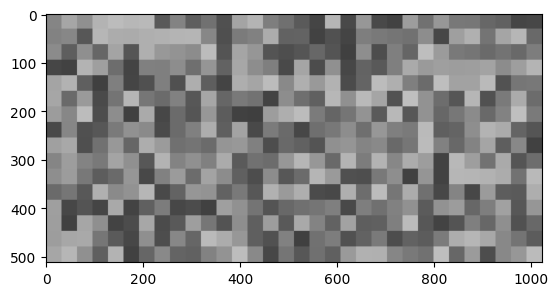

In [21]:
#@markdown If code crashes here, use smaller block size.
block_height = 32 #@param {type:"number"}
block_width = 32 #@param {type:"number"}
#@markdown Block width / height in pixel. **default: 32** for colab environment. _type: int_

sim = roicat.tracking.similarity_graph.ROI_graph(
    n_workers=1,  ## Number of CPU cores to use. -1 for all. For colab environment, 1 is safe.
    frame_height=data.FOV_height,
    frame_width=data.FOV_width,
    block_height=block_height,
    block_width=block_width,
    algorithm_nearestNeigbors_spatialFootprints='brute',  ## algorithm used to find the pairwise similarity for s_sf. ('brute' is slow but exact. See docs for others.)
    verbose=True,  ## Whether to print outputs
)

sim.visualize_blocks()

s_sf, s_NN, s_SWT, s_sesh = sim.compute_similarity_blockwise(
    spatialFootprints=blurrer.ROIs_blurred,  ## Mask spatial footprints
    features_NN=roinet.latents,  ## ROInet output latents
    features_SWT=swt.latents,  ## Scattering wavelet transform output latents
    ROI_session_bool=data.session_bool,  ## Boolean array of which ROIs belong to which sessions
    spatialFootprint_maskPower=1.0,  ##  An exponent to raise the spatial footprints to to care more or less about bright pixels
)

In [23]:
#@markdown It is useful to normalize the similarity matrices using the local ROIs....
sim.make_normalized_similarities(
    centers_of_mass=data.centroids,  ## ROI centroid positions
    features_NN=roinet.latents,  ## ROInet latents
    features_SWT=swt.latents,  ## SWT latents
    k_max=data.n_sessions*100,  ## Maximum number of nearest neighbors to consider for the normalizing distribution
    k_min=data.n_sessions*10,  ## Minimum number of nearest neighbors to consider for the normalizing distribution
    algo_NN='kd_tree',  ## Nearest neighbors algorithm to use
    device=DEVICE
)

Finding k-range of center of mass distance neighbors for each ROI...
Normalizing Neural Network similarity scores...


100%|██████████| 11943/11943 [00:01<00:00, 10429.67it/s]


Normalizing SWT similarity scores...


100%|██████████| 11943/11943 [00:04<00:00, 2654.74it/s]


# Clustering

This step does the following:
1. Mix the similarity matrices into a single distance matrix
2. Prune the distance matrix to remove low probability connections
3. Perform clustering
4. Compute quality metrics

###1. Mix the similarity matrices into a single distance matrix

This step finds the optimal parameters to mix the similarity matrices by tuning mixing parameters to maximally separate the distributions of pairwise similarities for ROI pairs known to be different and ROI pairs that are likely matched.

The details of how this is done:
1. Mix all the similarity matrices (`s_sf`, `s_NN_z`, `s_SWT_z`, `s_sesh`) into a single similarity matrix (`sConj`) by passing them through sigmoid functions and then taking the element-wise p-norm. This bounds the values between 0-1.
2. Convert `sConj` into a distance matrix `dConj`.
3. Define distribution of known 'different' ROIs as all the pairwise similarities of ROIs from the same sessions. Define the distribution of likely 'matched' ROIs as the 'different' distribution minus the distribution of 'all' pairwise similarities.
4. Define the objective function to minimize as the sum of the overlap between the 'same' and 'different' distributions, and optimize the mixing parameters (sigmoid function and p-norm parameters) over this objective.

In [24]:
#@markdown Initialize the clusterer object by passing the similarity matrices in...
clusterer = roicat.tracking.clustering.Clusterer(
    s_sf=sim.s_sf,
    s_NN_z=sim.s_NN_z,
    s_SWT_z=sim.s_SWT_z,
    s_sesh=sim.s_sesh,
)

kwargs_makeConjunctiveDistanceMatrix_best = clusterer.find_optimal_parameters_for_pruning(
    n_bins=None,  ## Number of bins to use for the histograms of the distributions
    smoothing_window_bins=None,  ## Number of bins to use to smooth the distributions
    kwargs_findParameters={
        'n_patience': 300,  ## Number of optimization epoch to wait for tol_frac to converge
        'tol_frac': 0.001,  ## Fractional change below which optimization will conclude
        'max_trials': 1200,  ## Max number of optimization epochs
        'max_duration': 60*10,  ## Max amount of time (in seconds) to allow optimization to proceed for
        'verbose': False,  ## Whether or not to print out updates every epoch
    },
    bounds_findParameters={
        'power_NN': (0., 5.),  ## Bounds for the exponent applied to s_NN
        'power_SWT': (0., 5.),  ## Bounds for the exponent applied to s_SWT
        'p_norm': (-5, 0),  ## Bounds for the p-norm p value (Minkowski) applied to mix the matrices
        'sig_NN_kwargs_mu': (0., 1.0),  ## Bounds for the sigmoid center for s_NN
        'sig_NN_kwargs_b': (0.00, 1.5),  ## Bounds for the sigmoid slope for s_NN
        'sig_SWT_kwargs_mu': (0., 1.0), ## Bounds for the sigmoid center for s_SWT
        'sig_SWT_kwargs_b': (0.00, 1.5),  ## Bounds for the sigmoid slope for s_SWT
    },
    n_jobs_findParameters=-1,  ## Number of CPU cores to use (-1 is all cores)
)

toc['separate_diffSame'] = time.time() - tic

Finding mixing parameters using automated hyperparameter tuning...
Best value found: 5929463.0 with parameters {'power_NN': 1.5116830383982776, 'power_SWT': 2.965919752006418, 'p_norm': -2.742744748225656, 'sig_NN_kwargs': {'mu': 0.06202882573098489, 'b': 1.027577054698335}, 'sig_SWT_kwargs': {'mu': 0.23796678030634555, 'b': 1.4880060830383122}}


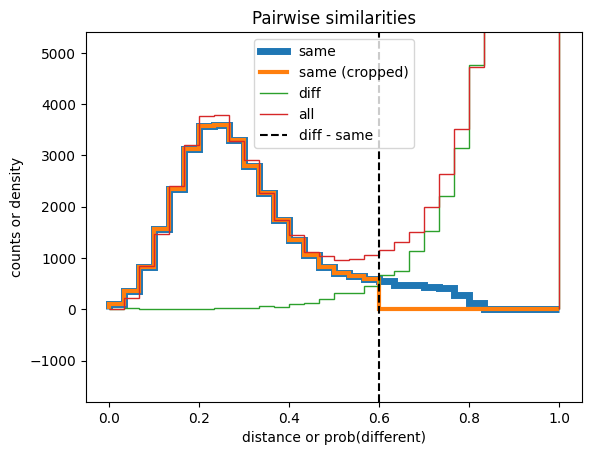

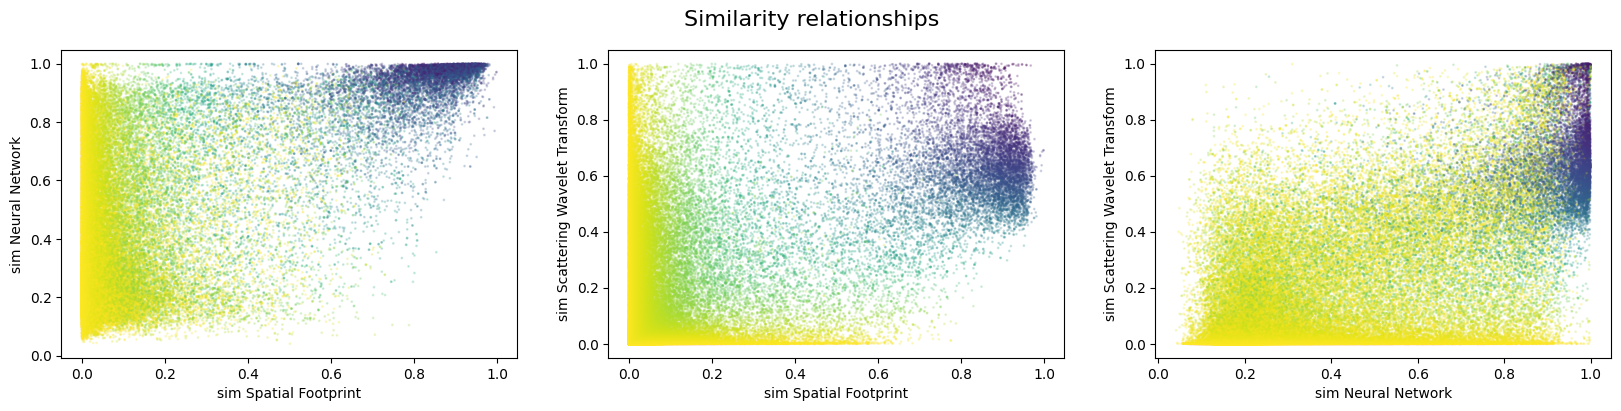

In [25]:
#@markdown Plot Pairwise similarities and relationships...
kwargs_mcdm_tmp = kwargs_makeConjunctiveDistanceMatrix_best  ## Use the optimized parameters

# kwargs_mcdm_tmp = {
#     'power_SF': 1.0,
#     'power_NN': 1.0,
#     'power_SWT': 0.0,
#     'p_norm': -4.0,
# #         'sig_SF_kwargs': {'mu':0.5, 'b':1.0},
#     'sig_SF_kwargs': None,
#         'sig_NN_kwargs': {'mu':1.0, 'b':0.5},
# #     'sig_NN_kwargs': None,
# #         'sig_SWT_kwargs': {'mu':0.5, 'b':1.0},
#     'sig_SWT_kwargs': None,
# }

clusterer.plot_distSame(kwargs_makeConjunctiveDistanceMatrix=kwargs_mcdm_tmp)

clusterer.plot_similarity_relationships(
    plots_to_show=[1,2,3],
    max_samples=100000,   ## Make smaller if it is running too slow
    kwargs_scatter={'s':1, 'alpha':0.2},
    kwargs_makeConjunctiveDistanceMatrix=kwargs_mcdm_tmp
);

###2. Prune the distance matrix

We can remove all connections in the distance graph with probabilities of connection of less than 50%. We estimate this cutoff distance as the cross-over point between the 'same' and 'different' distributions.


In [26]:
stringency = 1.0 #@param {type:"number"}
#@markdown This value changes the threshold for pruning the distance matrix.  **Default: 1.0**, _type: float_
#@markdown
#@markdown A higher value will result in less pruning, and a lower value will result in more pruning.
#@markdown
#@markdown The value will be multiplied by the inferred threshold to get the new one.


clusterer.make_pruned_similarity_graphs(
    d_cutoff=None,  ## (Optional) Manually specify a distance cutoff
    kwargs_makeConjunctiveDistanceMatrix=kwargs_makeConjunctiveDistanceMatrix_best,
    stringency=stringency,
    convert_to_probability=False,
)

Pruning similarity graphs with d_cutoff = 0.5999999642372131...


/usr/local/lib/python3.10/dist-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


###3. Cluster

There are two methods for clustering: The standard method `.fit` which is based on HDBSCAN, and `.fit_sequentialHungarian` which is an algorithm that is also used by CaImAn based on the Hungarian algorithm. The standard method takes 1-20 minutes and works better when there are many sessions, the Hungarian method takes seconds and works better when there are fewer sessions (<8).

In [27]:
#@markdown If you are tracking **8 or more sessions**...
min_cluster_size = 2 #@param {type:"number"}
#@markdown If you only want ROIs clusters with at least a certain number of samples, specify here. **Default: 2**, _type: int_
n_iter_violationCorrection = 6 #@param {type:"number"}
#@markdown This parameter controls how fast this step takes. Turning it down has mild effects on quality. **Default: 6**, _type: int_

#@markdown

#@markdown

#@markdown If you are tracking **less than 8 sessions**...
thresh_cost = 0.6 #@param {type:"number"}
#@markdown Determines the threshold of how distant two ROIs can be and still be matched. Smaller value is more stringent.
#@markdown
#@markdown **Default: 0.6**, _type: float_

if data.n_sessions >= 8:
    labels = clusterer.fit(
        d_conj=clusterer.dConj_pruned,  ## Input distance matrix
        session_bool=data.session_bool,  ## Boolean array of which ROIs belong to which sessions
        min_cluster_size=min_cluster_size,  ## Minimum number of ROIs that can be considered a 'cluster'
        n_iter_violationCorrection=n_iter_violationCorrection,  ## Number of times to redo clustering sweep after removing violations
        split_intraSession_clusters=True,  ## Whether or not to split clusters with ROIs from the same session
        cluster_selection_method='leaf',  ## (advanced) Method of cluster selection for HDBSCAN (see hdbscan documentation)
        d_clusterMerge=None,  ## Distance below which all ROIs are merged into a cluster
        alpha=0.999,  ## (advanced) Scalar applied to distance matrix in HDBSCAN (see hdbscan documentation)
        discard_failed_pruning=True,  ## (advanced) Whether or not to set all ROIs that could be separated from clusters with ROIs from the same sessions to label=-1
        n_steps_clusterSplit=100,  ## (advanced) How finely to step through distances to remove violations
    )

else:
    labels = clusterer.fit_sequentialHungarian(
        d_conj=clusterer.dConj_pruned,  ## Input distance matrix
        session_bool=data.session_bool,  ## Boolean array of which ROIs belong to which sessions
        thresh_cost=thresh_cost,  ## Threshold
    )


Clustering with CaImAn's sequential Hungarian algorithm method...


100%|██████████| 4/4 [00:01<00:00,  3.51it/s]


###4. Quality metrics

In [28]:
#@markdown Compute various quality scores for each cluster and each ROI...
quality_metrics = clusterer.compute_quality_metrics();

toc['clustering'] = time.time() - tic

/root/.local/lib/python3.10/site-packages/roicat/tracking/clustering.py:1124: UserWarning: Current version of silhouette samples calculation is memory intensive and will be improved when sklearn 1.3 is released.
  warnings.warn("Current version of silhouette samples calculation is memory intensive and will be improved when sklearn 1.3 is released.")


# Collect results

1. Make different versions of the labels for convenience.
2. Put all the useful results and info into a dictionary to save later
3. Put all the class objects from the run into a dictionary to save later

In [29]:
#@markdown Pulling results...
labels_squeezed, labels_bySession, labels_bool, labels_bool_bySession, labels_dict = roicat.tracking.clustering.make_label_variants(labels=labels, n_roi_bySession=data.n_roi)

results = {
    "clusters":{
        "labels": labels_squeezed,
        "labels_bySession": labels_bySession,
        "labels_bool": labels_bool,
        "labels_bool_bySession": labels_bool_bySession,
        "labels_dict": labels_dict,
    },
    "ROIs": {
        "ROIs_aligned": aligner.ROIs_aligned,
        "ROIs_raw": data.spatialFootprints,
        "frame_height": data.FOV_height,
        "frame_width": data.FOV_width,
        "idx_roi_session": np.where(data.session_bool)[1],
        "n_sessions": data.n_sessions,
    },
    "input_data": {
        "paths_stat": data.paths_stat,
        "paths_ops": data.paths_ops,
    },
    "quality_metrics": clusterer.quality_metrics,
}

run_data = copy.deepcopy({
    'data': data.serializable_dict,
    'aligner': aligner.serializable_dict,
    'blurrer': blurrer.serializable_dict,
    'roinet': roinet.serializable_dict,
    'swt': swt.serializable_dict,
    'sim': sim.serializable_dict,
    'clusterer': clusterer.serializable_dict,
})

### Visualize results

Look at some of the distributions of the quality metrics.
- Silhouette score is a particularly useful one for this type of clustering. Learn more [here](https://en.wikipedia.org/wiki/Silhouette_(clustering))
- We also define a handy 'confidence' variable which is a nice heuristic you can use for thresholding for inclusion criteria
- Note that the `sample_silhouette` score is a per-sample (per-ROI) score. So it can actually be used to remove / subselect ROIs from clusters.

In [30]:
print(f'Number of clusters: {len(np.unique(results["clusters"]["labels"]))}')
print(f'Number of discarded ROIs: {(results["clusters"]["labels"]==-1).sum()}')

Number of clusters: 2936
Number of discarded ROIs: 1682


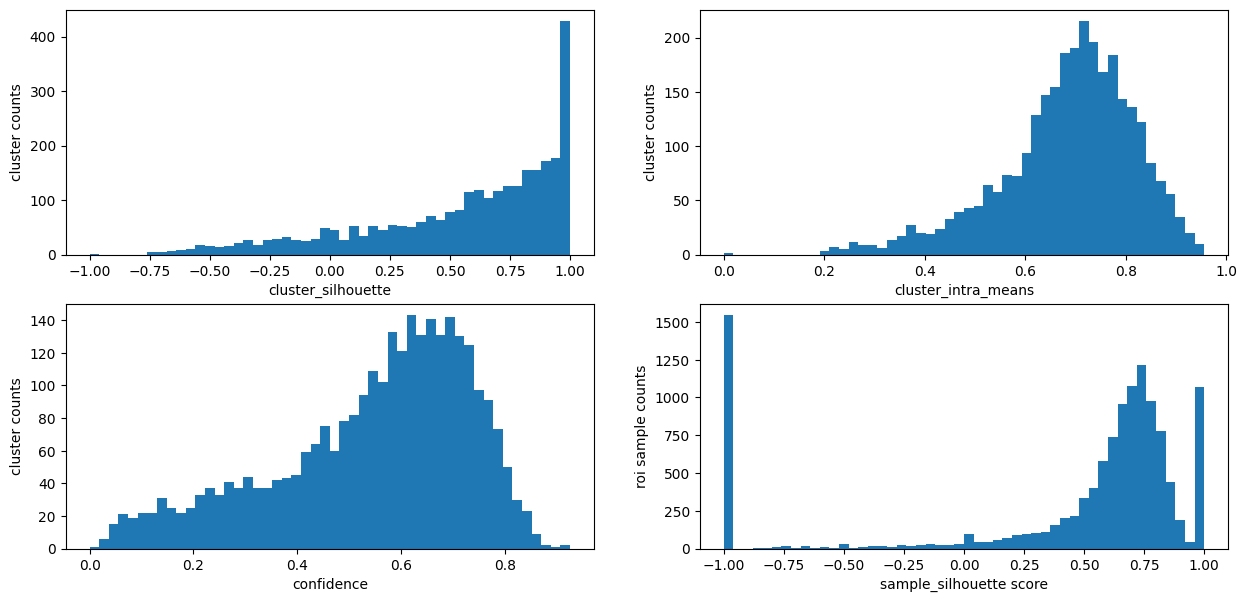

In [33]:
#@markdown Distributions of the quality metrics...
confidence = (((results['quality_metrics']['cluster_silhouette'] + 1) / 2) * results['quality_metrics']['cluster_intra_means'])

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15,7))

axs[0,0].hist(results['quality_metrics']['cluster_silhouette'], 50);
axs[0,0].set_xlabel('cluster_silhouette');
axs[0,0].set_ylabel('cluster counts');

axs[0,1].hist(results['quality_metrics']['cluster_intra_means'], 50);
axs[0,1].set_xlabel('cluster_intra_means');
axs[0,1].set_ylabel('cluster counts');

axs[1,0].hist(confidence, 50);
axs[1,0].set_xlabel('confidence');
axs[1,0].set_ylabel('cluster counts');

axs[1,1].hist(results['quality_metrics']['sample_silhouette'], 50);
axs[1,1].set_xlabel('sample_silhouette score');
axs[1,1].set_ylabel('roi sample counts');

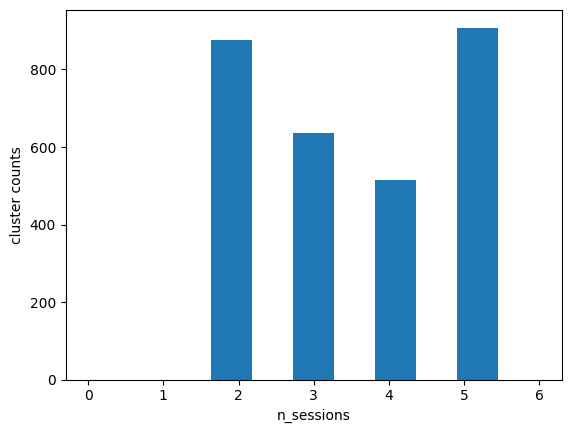

In [31]:
#@markdown Distribution of the cluster size...
_, counts = np.unique(results['clusters']['labels'], return_counts=True)

plt.figure()
plt.hist(counts, results['ROIs']['n_sessions']*2 + 1, range=(0, results['ROIs']['n_sessions']+1));
plt.xlabel('n_sessions'), plt.ylabel('cluster counts');

In [34]:
#@markdown Look at a color visualization of the results. ROIs of the same color are considered a part of the same cluster. The colors are assigned randomly.
FOV_clusters = roicat.visualization.compute_colored_FOV(
    spatialFootprints=[r.power(0.7) for r in results['ROIs']['ROIs_aligned']],  ## Spatial footprint sparse arrays
    FOV_height=results['ROIs']['frame_height'],
    FOV_width=results['ROIs']['frame_width'],
    labels=results["clusters"]["labels_bySession"],  ## cluster labels
    alphas_labels=confidence*1.5,  ## Set brightness of each cluster based on some 1-D array
#     alphas_sf=clusterer.quality_metrics['sample_silhouette'],  ## Set brightness of each ROI based on some 1-D array
)

roicat.visualization.display_toggle_image_stack(
    FOV_clusters,
    image_size=(np.array(FOV_clusters[0].shape)*1.5).astype(int)[:2],
    clim=[0,1.0],
)

Output hidden; open in https://colab.research.google.com to view.

/root/.local/lib/python3.10/site-packages/roicat/visualization.py:330: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(40,1))


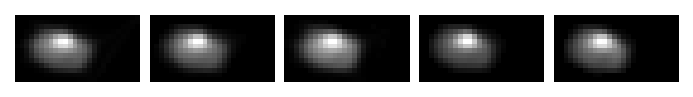

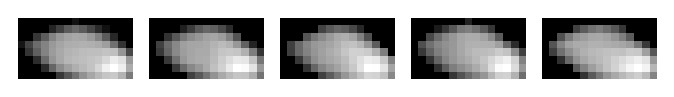

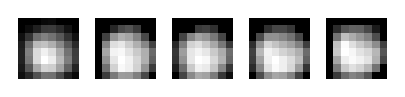

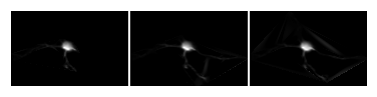

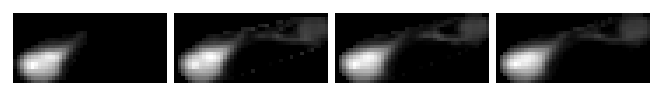

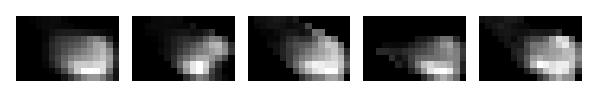

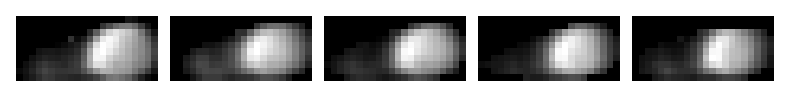

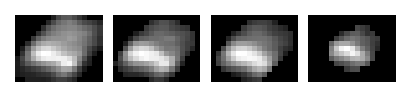

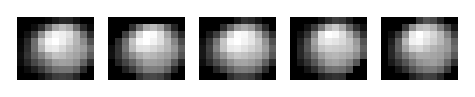

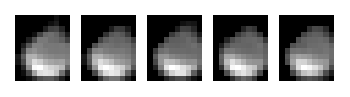

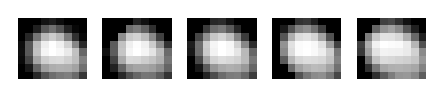

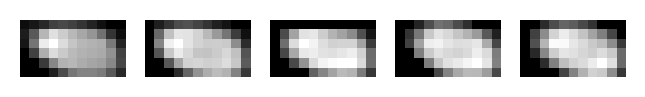

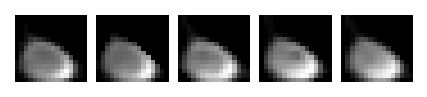

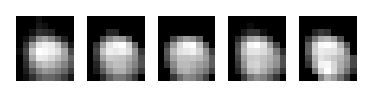

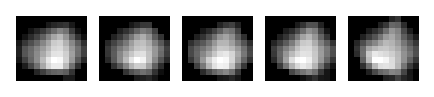

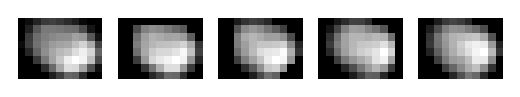

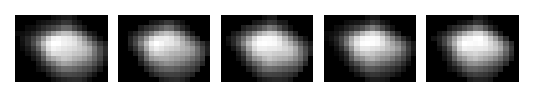

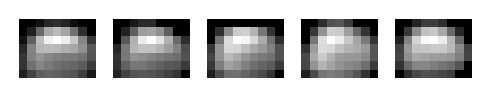

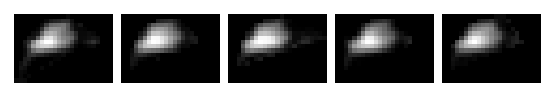

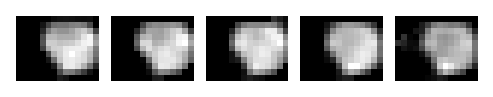

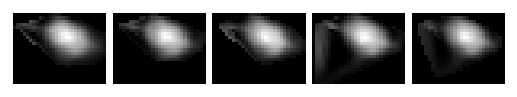

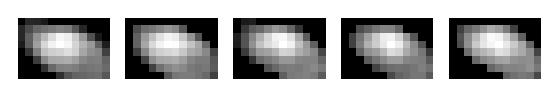

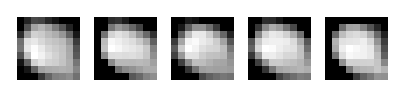

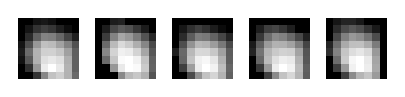

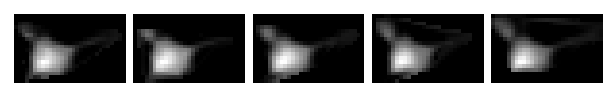

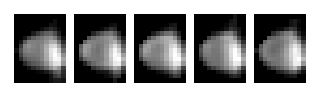

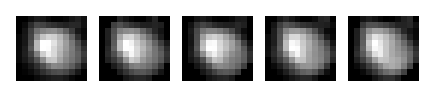

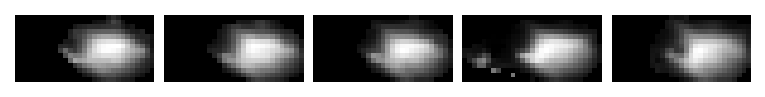

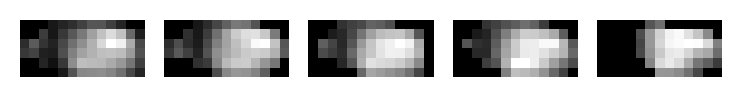

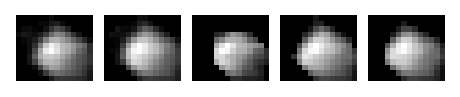

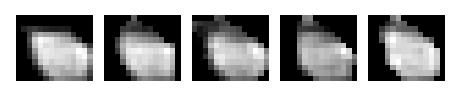

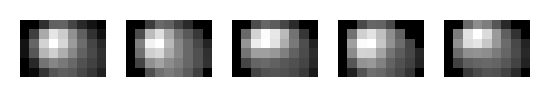

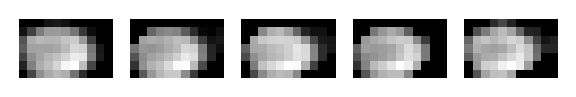

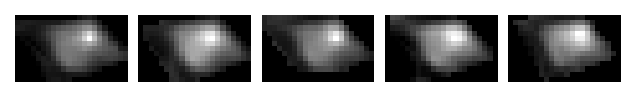

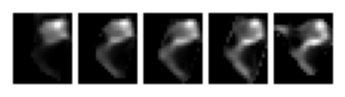

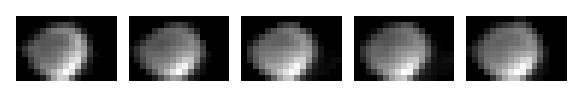

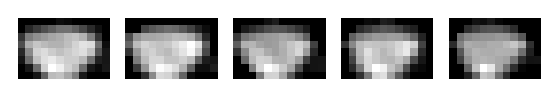

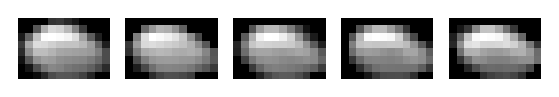

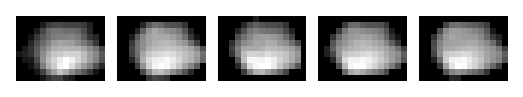

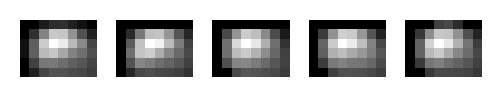

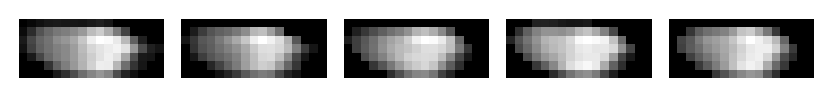

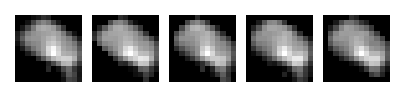

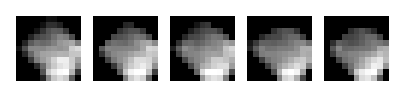

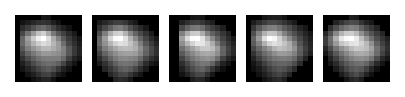

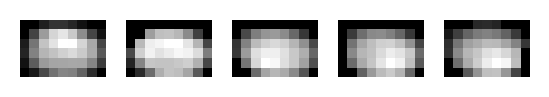

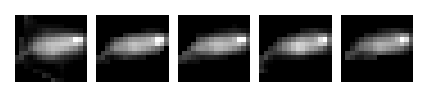

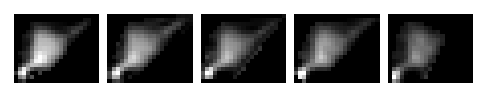

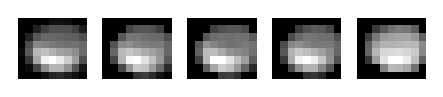

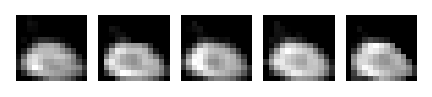

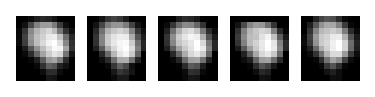

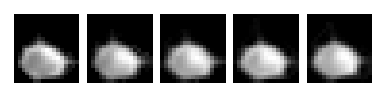

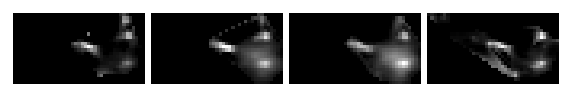

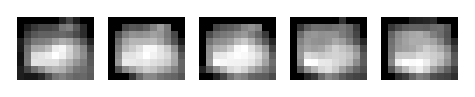

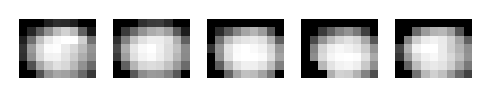

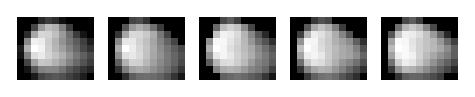

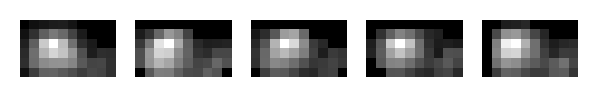

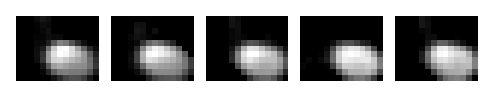

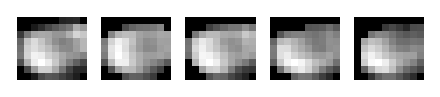

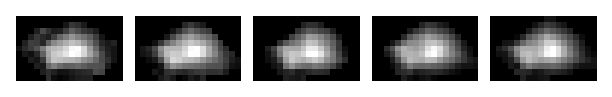

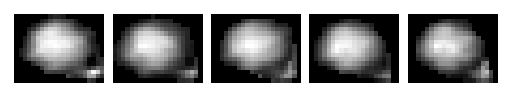

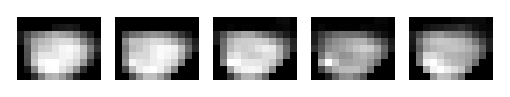

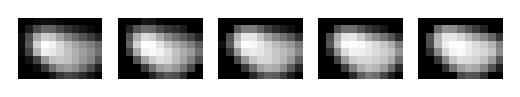

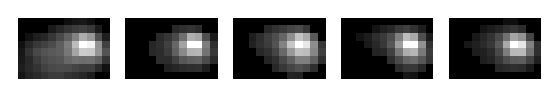

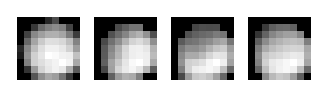

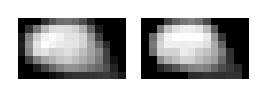

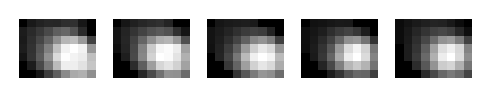

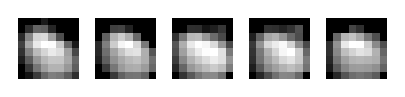

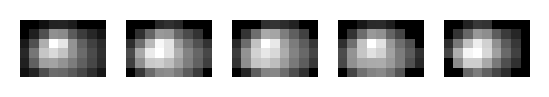

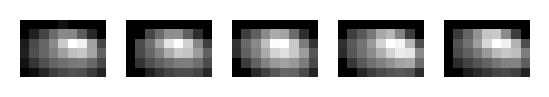

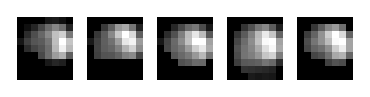

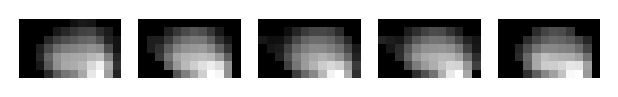

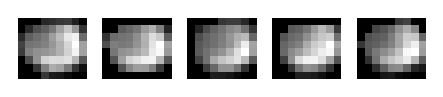

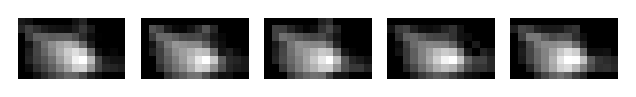

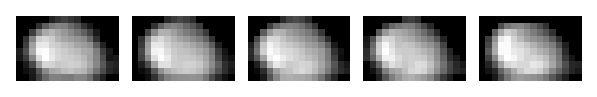

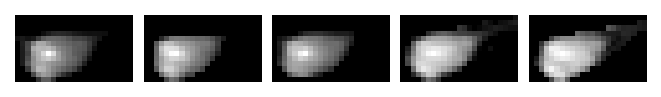

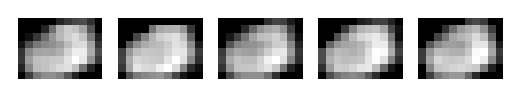

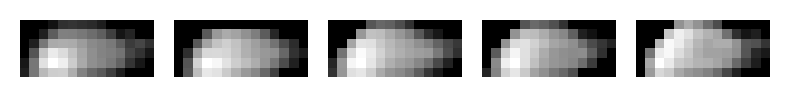

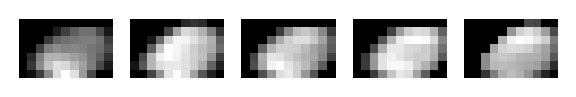

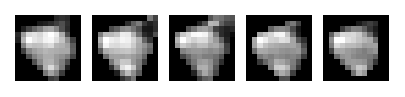

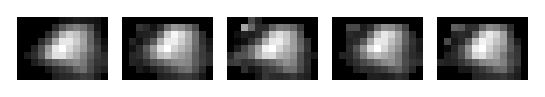

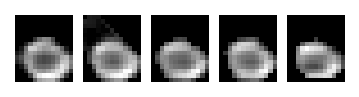

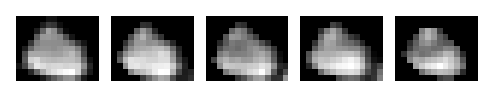

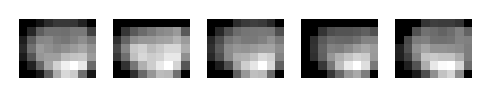

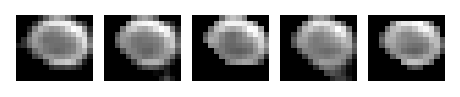

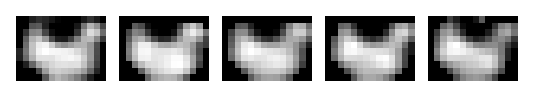

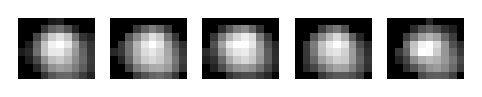

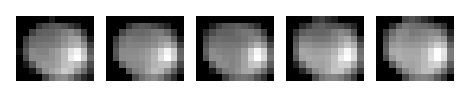

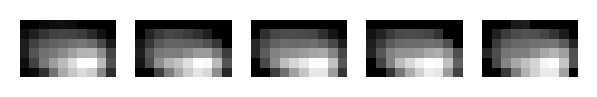

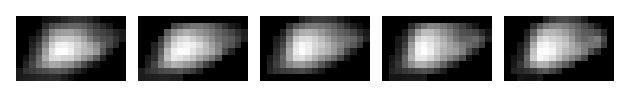

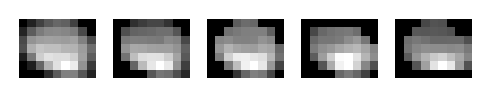

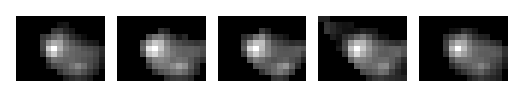

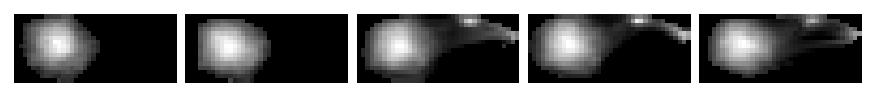

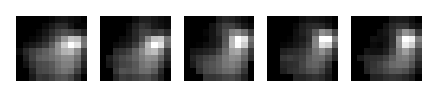

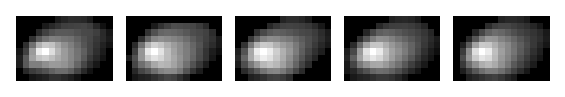

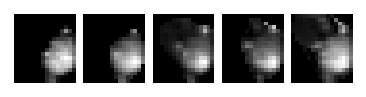

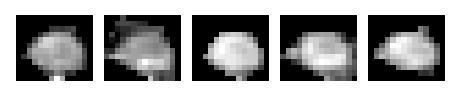

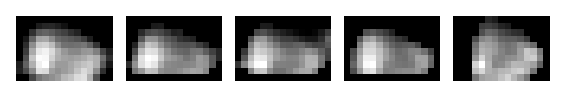

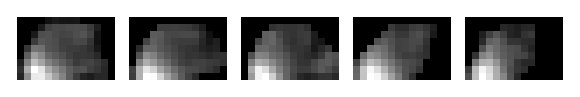

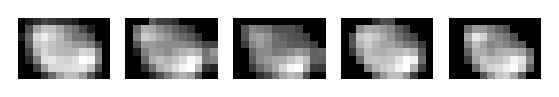

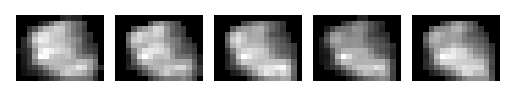

In [35]:
#@markdown Visualize the images of ROIs from the same cluster
unique_labels = np.unique(results["clusters"]["labels"][results["clusters"]["labels"]>-1])

if len(unique_labels) > 100:
  n_labels_to_display = 100
else:
  n_labels_to_display = int(unique_labels/10)

roicat.visualization.display_cropped_cluster_ims(
    spatialFootprints=results['ROIs']['ROIs_aligned'],
    labels=results["clusters"]["labels"],
    FOV_height=results['ROIs']['frame_height'],
    FOV_width=results['ROIs']['frame_width'],
    n_labels_to_display=n_labels_to_display,
)

### Save Results

In [36]:
#@markdown Save results in temporary Colab cloud...
jobs_done = datetime.now().strftime("%Y%m%d-%H%M%S")

tracking_save_filename = jobs_done + '_ROICaT.tracking.results' + '.pkl'
rundata_save_filename = jobs_done + '_ROICaT.tracking.rundata' + '.pkl'

tracking_path_save = Path.cwd() / tracking_save_filename
print(f'Tracking result on Colab cloud: {tracking_path_save}')

roicat.helpers.pickle_save(
    results,
    tracking_path_save,
    mkdir=True,
)

rundata_path_save = Path.cwd() / rundata_save_filename
print(f'Tracking Rundata on Colab cloud: {rundata_path_save}')

roicat.helpers.pickle_save(
    run_data,
    rundata_path_save,
    mkdir=True,
)


toc['saving'] = time.time() - tic
print("Process Time")
toc

Tracking result on Colab cloud: /content/20230627-014740_ROICaT.tracking.results.pkl
Tracking Rundata on Colab cloud: /content/20230627-014740_ROICaT.tracking.rundata.pkl
Process Time


{'start': 7.152557373046875e-05,
 'import_paths': 76.25180506706238,
 'import_data': 211.33231782913208,
 'blur': 1116.6836433410645,
 'NN': 1351.7020111083984,
 'SWT': 1553.0881595611572,
 'separate_diffSame': 1706.8816945552826,
 'clustering': 1770.456350326538,
 'saving': 1951.5616216659546}

In [37]:
#@markdown This cell saves output files to your gdrive.
import shutil

if ('path_gdrive' not in locals()) and ('path_gdrive' not in globals()):
  from google.colab import drive
  path_gdrive = '/content/gdrive'
  drive.mount(path_gdrive, force_remount=True)

tracking_copy_path = Path(path_gdrive) / 'MyDrive' / tracking_save_filename
rundata_copy_path = Path(path_gdrive) / 'MyDrive' / rundata_save_filename
shutil.copyfile(tracking_path_save, tracking_copy_path)
print(f'Tracking Result on your gdrive: {tracking_copy_path}')
shutil.copyfile(rundata_path_save, rundata_copy_path)
print(f'Tracking Rundata on your gdrive: {rundata_copy_path}')

Tracking Result on your gdrive: /content/gdrive/MyDrive/20230627-014740_ROICaT.tracking.results.pkl
Tracking Rundata on your gdrive: /content/gdrive/MyDrive/20230627-014740_ROICaT.tracking.rundata.pkl


In [ ]:
#@markdown This cell downloads output file to your local computer.

#@markdown Please note that **this process could be pretty slow!**
from google.colab import files
files.download(tracking_path_save)
files.download(rundata_path_save)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>